In [213]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12,5) # to set specific params(length, width) for the data 

In [214]:
data = pd.read_csv('web_traffic.csv', header=None, names=['Traffic', 'Period'])

In [231]:
from datetime import datetime

data['Period'] = pd.date_range(datetime.today(), periods=60).tolist()
data['Period']=data['Period'].apply(lambda x: x.strftime('%Y-%m-%d'))
data['Period']=pd.to_datetime(data['Period'])

In [232]:
data.set_index('Period', inplace=True)

In [233]:
data.tail()

,Traffic
Period,
2022-03-01,460
2022-03-02,480
2022-03-03,350
2022-03-04,470
2022-03-05,490


### Visualization

In [234]:
ts = data['Traffic']

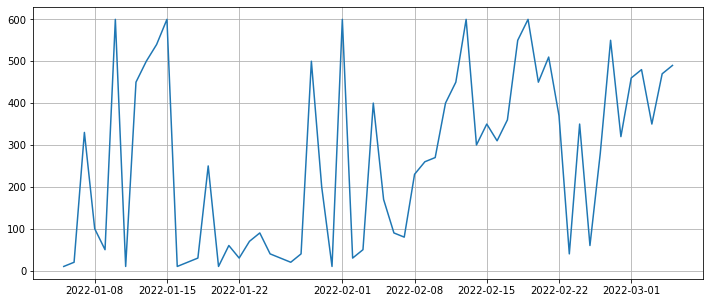

In [235]:
plt.plot(ts)
plt.grid()

### Decomposition

#### Log: log()

In [236]:
ts_log = np.log(ts)
ts_log.head()

Period
2022-01-05    2.302585
2022-01-06    2.995732
2022-01-07    5.799093
2022-01-08    4.605170
2022-01-09    3.912023
Name: Traffic, dtype: float64

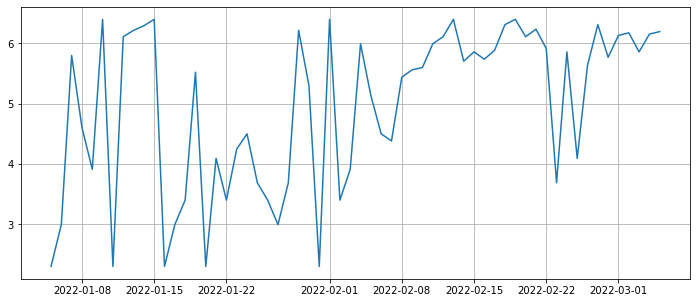

In [237]:
plt.plot(ts_log)
plt.grid()

### Stationary Check

In [238]:
from statsmodels.tsa.stattools import adfuller, acf, pacf

def test_stationarity(timeseries):
    rolmean = timeseries.rolling(window=6, center=False).mean()
    rolstd = timeseries.rolling(window=6,center=False).std()
    
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    
    plt.legend(loc='best')
    plt.title('Rolling Mean and Std Deviation')
    plt.grid()
    plt.show(block=False)
    
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags U','Number of Observations used'])
    
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

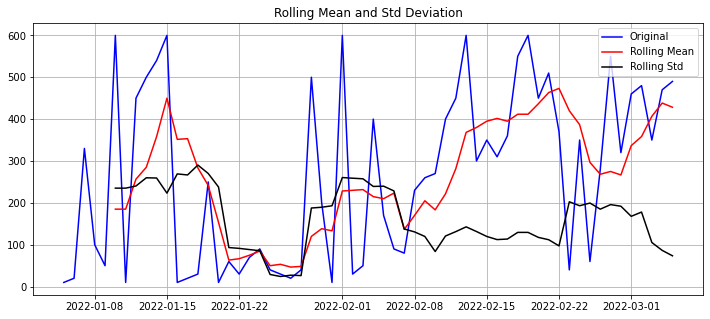

Results of Dickey-Fuller Test:
Test Statistic                 -2.656953
p-value                         0.081788
#Lags U                         3.000000
Number of Observations used    56.000000
Critical Value (1%)            -3.552928
Critical Value (5%)            -2.914731
Critical Value (10%)           -2.595137
dtype: float64


In [239]:
test_stationarity(data['Traffic'])

the p-value is 0.081788, the data need to be stationarised

### Initialize moving standard deviation variable

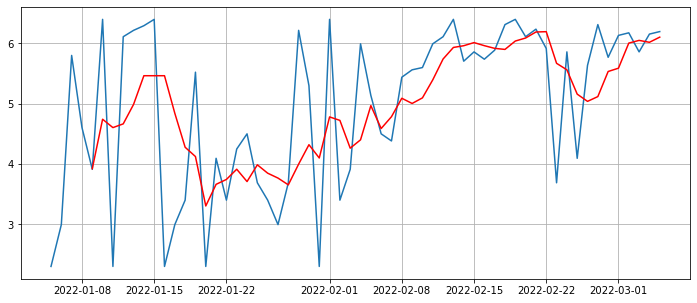

In [241]:
movingAverage = ts_log.rolling(window=5).mean()
movingSTD = ts_log.rolling(window=5).std()

plt.grid()
plt.plot(ts_log)
plt.plot(movingAverage, color='red')

In [242]:
ts_log_mv_diff = ts_log - movingAverage
ts_log_mv_diff.head(12)

ts_log_mv_diff.dropna(inplace=True)
ts_log_mv_diff.head(10)

Period
2022-01-05         NaN
2022-01-06         NaN
2022-01-07         NaN
2022-01-08         NaN
2022-01-09   -0.010898
2022-01-10    1.655140
2022-01-11   -2.300575
2022-01-12    1.444056
2022-01-13    1.227529
2022-01-14    0.828581
2022-01-15    0.933942
2022-01-16   -3.160403
Name: Traffic, dtype: float64

#### pasrsing the time series data into the fucntion and check for stationarity

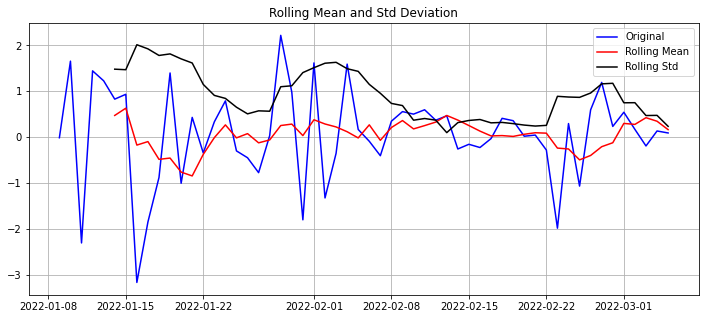

Results of Dickey-Fuller Test:
Test Statistic                 -5.355181
p-value                         0.000004
#Lags U                         3.000000
Number of Observations used    52.000000
Critical Value (1%)            -3.562879
Critical Value (5%)            -2.918973
Critical Value (10%)           -2.597393
dtype: float64


In [244]:
test_stationarity(ts_log_mv_diff)

the data looks stationary, also the p-value is 0.000004

### Plotting ACF

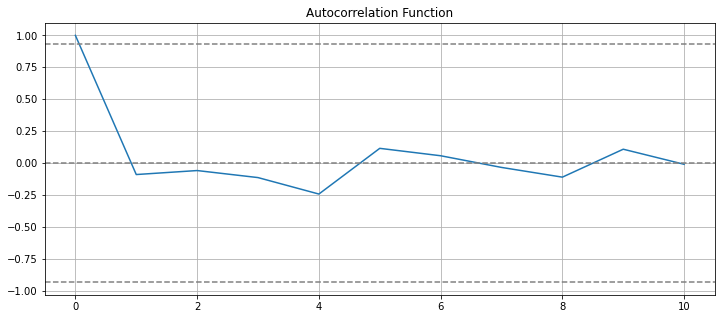

In [245]:
plt.plot(np.arange(0,11), acf(ts_log_mv_diff,nlags=10))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-7/np.sqrt(len(ts_log_mv_diff)),linestyle='--',color='gray')
plt.axhline(y=7/np.sqrt(len(ts_log_mv_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
plt.grid()
plt.show()

value of q = MA = 1 per the ACF curve

### Plotting PACF

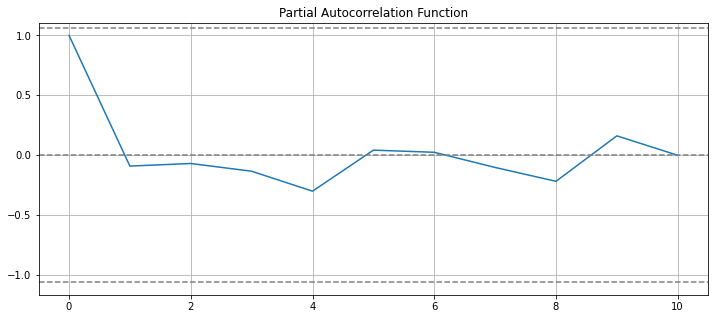

In [246]:
plt.plot(np.arange(0,11), pacf(ts_log_mv_diff,nlags=10))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts_log_mv_diff)),linestyle='--',color='gray')
plt.axhline(y=7.96/np.sqrt(len(ts_log_mv_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.grid()
plt.show()

value of p = AR = 1 per the PACF curve

### ARIMA

Text(0.5, 1.0, 'RSS: nan')

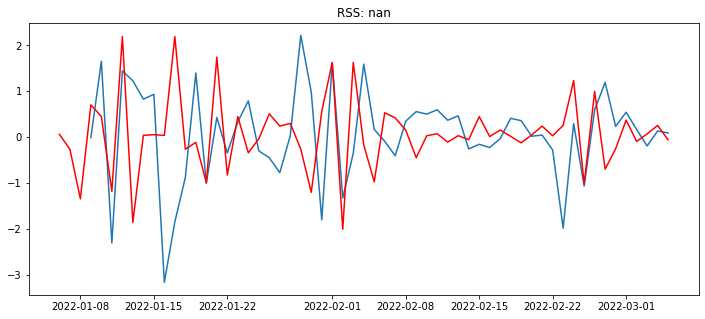

In [247]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(ts_log,order=(1,1,0))
results_ARIMA = model.fit(disp=-1)
plt.plot(ts_log_mv_diff)
plt.plot(results_ARIMA.fittedvalues,color='red')
plt.title('RSS: %.4f'%sum((results_ARIMA.fittedvalues[1:]-ts_log_mv_diff)**2))

In [248]:
data['forecast']=results_ARIMA.predict(start=10, end=80, dynamic=True)

<AxesSubplot:xlabel='Period'>

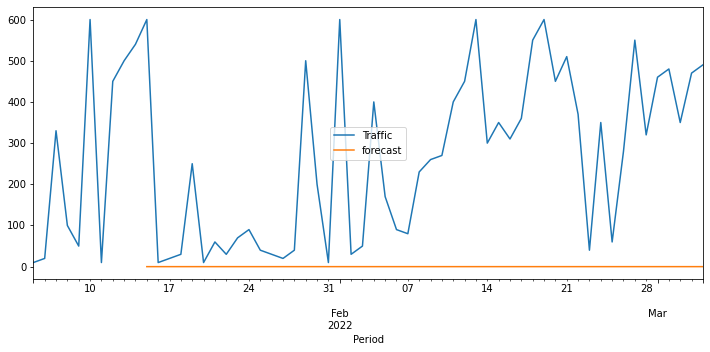

In [249]:
data[['Traffic','forecast']].plot()

In [250]:
data=data.drop(columns=['forecast'], axis=1)

### Series

passing the fitted cvalues in to the pd.Series()

In [251]:
results_ARIMA.fittedvalues

Period
2022-01-06    0.062463
2022-01-07   -0.260454
2022-01-08   -1.340902
2022-01-09    0.705743
2022-01-10    0.449342
2022-01-11   -1.177851
2022-01-12    2.190785
2022-01-13   -1.854602
2022-01-14    0.040498
2022-01-15    0.055039
2022-01-16    0.040498
2022-01-17    2.190785
2022-01-18   -0.260454
2022-01-19   -0.113158
2022-01-20   -0.991150
2022-01-21    1.742537
2022-01-22   -0.822953
2022-01-23    0.449342
2022-01-24   -0.339380
2022-01-25   -0.034231
2022-01-26    0.509648
2022-01-27    0.241740
2022-01-28    0.302046
2022-01-29   -0.260454
2022-01-30   -1.198752
2022-01-31    0.563593
2022-02-01    1.628286
2022-02-02   -2.001897
2022-02-03    1.628286
2022-02-04   -0.167103
2022-02-05   -0.970249
2022-02-06    0.532553
2022-02-07    0.420076
2022-02-08    0.154750
2022-02-09   -0.446264
2022-02-10    0.031671
2022-02-11    0.075121
2022-02-12   -0.106797
2022-02-13    0.034138
2022-02-14   -0.052852
2022-02-15    0.449342
2022-02-16    0.015517
2022-02-17    0.156582
2022

In [253]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(type(predictions_ARIMA_diff),"\n",predictions_ARIMA_diff.head())

<class 'pandas.core.series.Series'> 
 Period
2022-01-06    0.062463
2022-01-07   -0.260454
2022-01-08   -1.340902
2022-01-09    0.705743
2022-01-10    0.449342
dtype: float64


### cumsum()

cumsum the fitted values

In [254]:
predictions_ARIMA_diff_cum = predictions_ARIMA_diff.cumsum()
print(type(predictions_ARIMA_diff_cum),"\n",predictions_ARIMA_diff_cum.head())

<class 'pandas.core.series.Series'> 
 Period
2022-01-06    0.062463
2022-01-07   -0.197991
2022-01-08   -1.538893
2022-01-09   -0.833150
2022-01-10   -0.383808
dtype: float64


### add()

adding the intitial value of ts_log to all the predictions_ARIMA_cum

In [255]:
predictions_ARIMA_log = pd.Series(ts_log.iloc[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cum, fill_value=0)
print(type(predictions_ARIMA_log),"\n",predictions_ARIMA_log.head())

<class 'pandas.core.series.Series'> 
 Period
2022-01-05    2.302585
2022-01-06    2.365048
2022-01-07    2.104594
2022-01-08    0.763692
2022-01-09    1.469435
dtype: float64


Text(0.5, 1.0, 'RMSE: 266.9630')

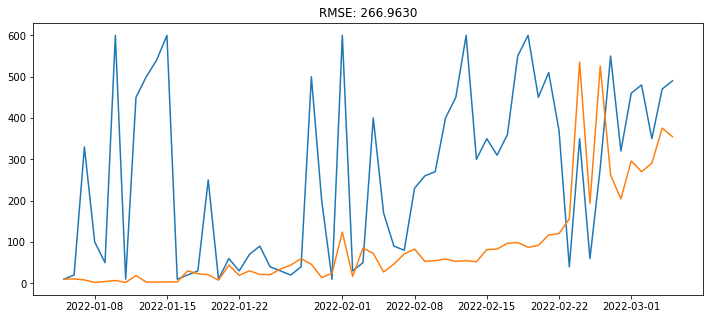

In [256]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'%np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))

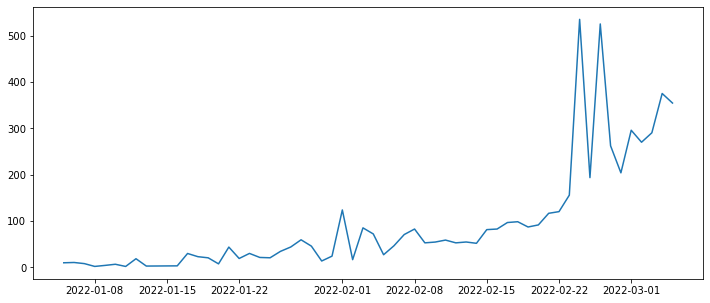

In [257]:
plt.plot(predictions_ARIMA)

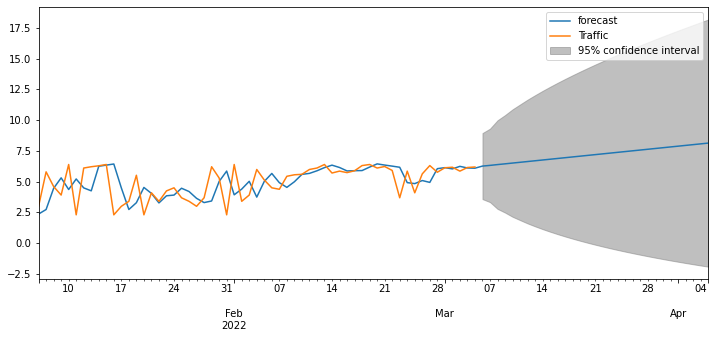

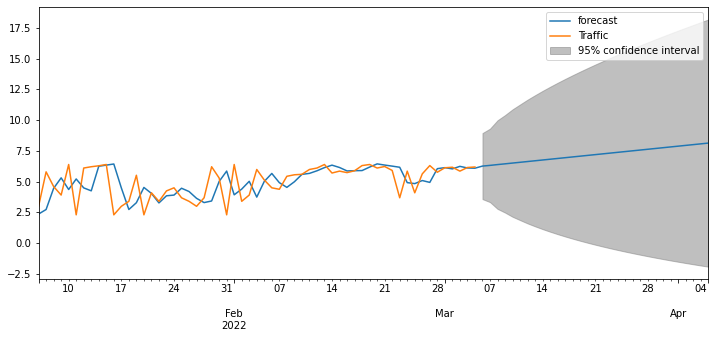

In [258]:
results_ARIMA.plot_predict(1,90)